In [ ]:
# get the first chronological million transaction inputs
start_time = time.time()
tx_in_list = []
counter = 0
num_transactions = 1000000 
with open('../data/txin.txt', 'r') as f:
    reader = csv.reader(f, delimiter = '\t')
    for row in reader:
        counter += 1
        if np.mod(counter, 1000000) == 0:
            print(counter)
        # Assuming transactions start at 0 and increase incrementally,
        # Create a list of all rows with transaction id's under 1,000,000
        if int(row[0]) in range(num_transactions):
            tx_in_list.append(row)
            
    f.close()
print("tx_in read runtime = {}".format(time.time() - start_time))
with open('../small_data/tx_in_500k.txt', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerows(tx_in_list)
    f.close()

In [ ]:
# get the first chronological million transaction inputs
start_time = time.time()
tx_in_list = []
counter = 0
num_transactions = 1000000 
with open('../data/txout.txt', 'r') as f:
    reader = csv.reader(f, delimiter = '\t')
    for row in reader:
        counter += 1
        if np.mod(counter, 1000000) == 0:
            print(counter)
        # Assuming transactions start at 0 and increase incrementally,
        # Create a list of all rows with transaction id's under 1,000,000
        if int(row[0]) in range(num_transactions):
            tx_in_list.append(row)
            
    f.close()
print("tx_out read runtime = {}".format(time.time() - start_time))
with open('../small_data/tx_out_500k.txt', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerows(tx_in_list)
    f.close()

In [1]:
from graph_tool.all import *
import pandas as pd
import numpy as np
import csv
import time
import json
import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_transaction_data(input_file, output_file, num_transactions):
    ## This function runs in constant time because it must read each line of the input data file.
    start_time = time.time()
    tx_in_list = []
    counter = 0
    with open(input_file, 'r') as f:
        reader = csv.reader(f, delimiter = '\t')
        for row in reader:
            counter += 1
            if np.mod(counter, 1000000) == 0:
                print(counter)
            # Assuming transactions start at 0 and increase incrementally,
            # Create a list of all rows with transaction id's under num_transactions
            if int(row[0]) in range(num_transactions):
                tx_in_list.append(row)

        f.close()
    print("tx_in read runtime = {}".format(time.time() - start_time))
    with open(output_file, 'w') as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerows(tx_in_list)
        f.close()

In [67]:
# get the first 10k transactions
get_transaction_data('../data/txin.txt', '../small_data/tx_in_10k.txt', 10000)

1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
37000000
38000000
39000000
40000000
41000000
42000000
43000000
44000000
45000000
46000000
47000000
48000000
49000000
50000000
51000000
52000000
53000000
54000000
55000000
56000000
57000000
58000000
59000000
60000000
61000000
62000000
63000000
64000000
65000000
66000000
67000000
68000000
69000000
70000000
71000000
72000000
73000000
74000000
75000000
76000000
77000000
78000000
79000000
80000000
81000000
82000000
83000000
84000000
85000000
86000000
87000000
88000000
89000000
90000000
91000000
92000000
93000000
94000000
95000000
96000000
97000000
98000000
99000000
100000000
101000000
102000000
103000000
104000000
105000000
106000000
107000000
108000000
109000000
110000000
11100000

In [3]:
def create_dataframes(tx_input_file, tx_output_file):
    # Read smaller transaction files into dataframes
    in_df = pd.read_csv(tx_input_file, delimiter='\t')
    in_df.columns = ['tx_id', 'input_id', 'sending_address', 'value']

    out_df = pd.read_csv(tx_output_file, delimiter='\t')
    out_df.columns = ['tx_id', 'output_id', 'receiving_address', 'value']
    
    ## Get rid of bitcoin spawning transactions
    # First identify transactions to remove
    input_ids = set(in_df.tx_id)
    output_ids = set(out_df.tx_id)
    intersection = input_ids.intersection(output_ids)
    union = input_ids.union(output_ids)
    outliers = union - intersection
    print("There are {} transaction id's which do not occur in both files".format(len(outliers)))
    print("This discrepancy is because miners create bitcoin")

    # Remove transactoins
    print("In before: {}".format(in_df.shape[0]))
    print("Out before: {}".format(out_df.shape[0]))
    in_df = in_df[in_df['tx_id'].isin(intersection)]
    out_df = out_df[out_df['tx_id'].isin(intersection)]
    print("In after: {}".format(in_df.shape[0]))
    print("Out after: {}".format(out_df.shape[0]))
    return in_df, out_df


In [4]:
## Collect transaction timestamps from tx.txt
def get_tx_timestamps(number_of_transactions):
    # tx.txt is sorted by transaction id. Just take rows 0 : num_transactions
    counter = 0
    number_of_transactions = 1000000
    start = time.time()
    print("Finding block to transaction relation")
    block_transaction_list = []
    ## tx.txt is a sorted list of transaction ids. Dont search more than we need to or it'll take forever.
    with open('../data/tx.txt', 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        for row in reader:
            if counter < number_of_transactions:
                block_transaction_list.append(row)
            else:
                break
            counter += 1
            if np.mod(counter, 10000) == 0:
                print(counter)
        f.close()
    print("Took {} seconds".format(time.time() - start))

    # From the transactions/timestamp list, create a dictionary to efficiently add to dataframe
    tx_time = {}
    for row in block_transaction_list:
        tx_time[row[0]] = row[-1]
    return tx_time

In [63]:
# Add a column for the timestamp based off of the transaction id in each row.
in_df['time'] = in_df.apply(lambda row: tx_time[str(row.tx_id)], axis=1)
out_df['time'] = out_df.apply(lambda row: tx_time[str(row.tx_id)], axis=1)

In [6]:
def main():
    big_tx_in = '../data/txin.txt'
    small_tx_in = '../small_data/tx_in_10k.txt'
    number_of_transactions = 10000
    
    big_tx_out = '../data/txout.txt'
    small_tx_out = '../small_data/tx_out_10k.txt'
    
    # Get subset of all data
    get_transaction_data(big_tx_in, small_tx_in, number_of_transactions)
    get_transaction_data(big_tx_out, small_tx_out, number_of_transactions)
    
    in_df, out_df = create_dataframes(small_tx_in, small_tx_out)
    
    tx_time = get_tx_timestamps(number_of_transactions)
    
    # Add a column for the timestamp based off of the transaction id in each row.
    in_df['time'] = in_df.apply(lambda row: tx_time[str(row.tx_id)], axis=1)
    out_df['time'] = out_df.apply(lambda row: tx_time[str(row.tx_id)], axis=1)
    return in_df, out_df

In [19]:
small_tx_in = '../small_data/tx_in_10k.txt'
small_tx_out = '../small_data/tx_out_10k.txt'
number_of_transactions = 10000
in_df, out_df = create_dataframes(small_tx_in, small_tx_out)

tx_time = get_tx_timestamps(number_of_transactions)

# Add a column for the timestamp based off of the transaction id in each row.
in_df['time'] = in_df.apply(lambda row: tx_time[str(row.tx_id)], axis=1)
out_df['time'] = out_df.apply(lambda row: tx_time[str(row.tx_id)], axis=1)


There are 9909 transaction id's which do not occur in both files
This discrepancy is because miners create bitcoin
In before: 607
Out before: 10026
In after: 607
Out after: 117
Finding block to transaction relation
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
Took 3.352492094039917 seconds


In [7]:
in_df, out_df = main()

1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
37000000
38000000
39000000
40000000
41000000
42000000
43000000
44000000
45000000
46000000
47000000
48000000
49000000
50000000
51000000
52000000
53000000
54000000
55000000
56000000
57000000
58000000
59000000
60000000
61000000
62000000
63000000
64000000
65000000
66000000
67000000
68000000
69000000
70000000
71000000
72000000
73000000
74000000
75000000
76000000
77000000
78000000
79000000
80000000
81000000
82000000
83000000
84000000
85000000
86000000
87000000
88000000
89000000
90000000
91000000
92000000
93000000
94000000
95000000
96000000
97000000
98000000
99000000
100000000
101000000
102000000
103000000
104000000
105000000
106000000
107000000
108000000
109000000
110000000
11100000

In [13]:
in_df

In [21]:
in_df.sort_values('tx_id', inplace=True, ascending=True)
out_df.sort_values('tx_id', inplace=True, ascending=True)

In [27]:
tx_ids = list(set(in_df.tx_id))
tx_ids

[533,
 8226,
 555,
 557,
 558,
 559,
 1075,
 1077,
 1613,
 7757,
 6226,
 6227,
 600,
 601,
 2649,
 7256,
 609,
 3701,
 8861,
 5281,
 5282,
 5285,
 5286,
 171,
 1206,
 183,
 6839,
 185,
 6840,
 187,
 6843,
 192,
 8399,
 8400,
 724,
 1236,
 7388,
 227,
 2788,
 9444,
 746,
 5875,
 6399,
 255,
 1795,
 2308,
 6416,
 3358,
 2847,
 2848,
 2849,
 3362,
 3363,
 2850,
 2851,
 3361,
 2853,
 2854,
 2855,
 1320,
 2856,
 2857,
 2862,
 2863,
 2864,
 8020,
 8021,
 5986,
 3940,
 4465,
 4468,
 4470,
 4989,
 6530,
 9093,
 1414,
 9094,
 9095,
 2962,
 2964,
 3994,
 2972,
 1974,
 962,
 1480,
 1997,
 3565,
 2550,
 504,
 4602]

In [44]:
type(tx_ids[0])

numpy.int64

In [77]:
in_df

tx_id  input_id  sending_address       value        time
8      171         0          1687416  5000000000  1231731025
9      183         0          1687416  4000000000  1231740133
10     185         0          1687416  3000000000  1231740736
11     187         0          1687416  2900000000  1231742062
44     192         0          7894664   100000000  1231744600
513    227         0        101635574   100000000  1231770060
12     255         0          1687416  2800000000  1231790660
282    504         2         53048833  1000000000  1231965655
96     504         1         19225707   100000000  1231965655
177    504         0         35811624  5000000000  1231965655
449    533         0         87947477  5000000000  1231983986
323    555         0         59966218  2500000000  1231998512
337    557         0         64064811   100000000  1231999700
324    557         1         59966218  2400000000  1231999700
338    558         1         64064811  2400000000  1231999700
466    558         0         91987224   100000000  1231999700
467    559         0         91987224   100000000  1231999700
468    559         1         91987224  2400000000  1231999700
334    600         0         61836210  5000000000  1232029520
348    600         1         66937703  5000000000  1232029520
498    600         4         98303899  5000000000  1232029520
222    600         2         44014304  5000000000  1232029520
221    600         3         43872557  5000000000  1232029520
341    601         0         64528685  5000000000  1232029520
77     609         0         16327307  5000000000  1232034716
158    724         1         29857390  5000000000  1232113906
32     724         0          5792250  5000000000  1232113906
172    746         1         34589353  5000000000  1232133515
528    746         0        104176454  5000000000  1232133515
311    962         0         56855477  5000000000  1232308979
..     ...       ...              ...         ...         ...
253   9444         3         48713310  5000000000  1238514389
73    9444        31         15360834  5000000000  1238514389
227   9444        18         44140541  5000000000  1238514389
368   9444        29         70244983  5000000000  1238514389
370   9444         6         71358955  5000000000  1238514389
202   9444        19         43146819  5000000000  1238514389
385   9444         0         74840395  5000000000  1238514389
604   9444        24        121307962  5000000000  1238514389
387   9444        30         75021939  5000000000  1238514389
236   9444        28         45970036  5000000000  1238514389
118   9444        21         23494192  5000000000  1238514389
190   9444        14         40109089  5000000000  1238514389
21    9444         4          4192695  5000000000  1238514389
508   9444         8        100450397  5000000000  1238514389
31    9444        20          5696211  5000000000  1238514389
152   9444        17         29142499  5000000000  1238514389
15    9444        22          2807564  5000000000  1238514389
489   9444         1         96820443  5000000000  1238514389
484   9444         5         95547576  5000000000  1238514389
404   9444        27         78798525  5000000000  1238514389
471   9444         9         92781077  5000000000  1238514389
459   9444        16         89975142  5000000000  1238514389
455   9444        11         88350789  5000000000  1238514389
185   9444        25         38905646  5000000000  1238514389
422   9444        26         82674888  5000000000  1238514389
187   9444        12         39291320  5000000000  1238514389
581   9444        15        116538854  5000000000  1238514389
133   9444        13         25777197  5000000000  1238514389
166   9444        23         33667924  5000000000  1238514389
105   9444         2         20831291  5000000000  1238514389

[607 rows x 5 columns]

In [43]:
out_df

tx_id  output_id  receiving_address         value        time
9763    171          0          118184441    1000000000  1231731025
133     171          1            1687416    4000000000  1231731025
134     183          1            1687416    3000000000  1231740133
5247    183          0           63043938    1000000000  1231740133
135     185          1            1687416    2900000000  1231740736
8379    185          0          101635574     100000000  1231740736
673     187          0            7894664     100000000  1231742062
136     187          1            1687416    2800000000  1231742062
1627    192          0           19225707     100000000  1231744600
4110    227          0           49460988     100000000  1231770060
137     255          1            1687416    1800000000  1231790660
4414    255          0           53048833    1000000000  1231790660
4091    504          0           49110323    6100000000  1231965655
4965    533          0           59966218    2500000000  1231983986
7301    533          1           87947477    2500000000  1231983986
5323    555          0           64064811     100000000  1231998512
4966    555          1           59966218    2400000000  1231998512
7608    557          0           91987224     100000000  1231999700
5324    557          1           64064811    2400000000  1231999700
7609    558          0           91987224     100000000  1231999700
7610    558          1           91987224    2400000000  1231999700
7611    559          1           91987224    2400000000  1231999700
5325    559          0           64064811     100000000  1231999700
3380    600          0           40757926   25000000000  1232029520
9881    601          0          119764812    5000000000  1232029520
8126    609          0           98199083    2500000000  1232034716
1379    609          1           16327307    2500000000  1232034716
489     724          0            5898913   10000000000  1232113906
208     746          0            2624888   10000000000  1232133515
4440    962          0           53330575   15000000000  1232308979
...     ...        ...                ...           ...         ...
215    4602          0            2624888  150000000000  1234810654
216    4989          0            2624888   80000000000  1235087435
7815   5281          0           94203744   20000000000  1235298745
1886   5282          0           22332495    5000000000  1235298745
6223   5285          0           75026122   40000000000  1235299853
3135   5286          0           37856265   40000000000  1235299853
217    5875          0            2624888  180000000000  1235764143
3136   5986          0           37856265   35000000000  1235859214
3137   6226          0           37856265   25000000000  1236054265
3138   6227          0           37856265   15000000000  1236054265
218    6399          0            2624888  120000000000  1236194891
219    6416          0            2624888      33000000  1236209362
61     6416          1             828730    4967000000  1236209362
220    6530          0            2624888   40000000000  1236297007
8029   6839          0           96857558    5000000000  1236532492
2072   6840          0           24353274   30000000000  1236532492
3139   6843          0           37856265  120000000000  1236534402
4568   7256          0           54951669   15000000000  1236854934
3140   7388          0           37856265   75000000000  1236954375
221    7757          0            2624888  240000000000  1237221615
3141   8020          0           37856265   55000000000  1237419496
3142   8021          0           37856265   15000000000  1237419496
222    8226          0            2624888   60000000000  1237567953
3143   8399          0           37856265   30000000000  1237739482
3144   8400          0           37856265   25000000000  1237739482
223    8861          0            2624888  140000000000  1238080902
3145   9093          0           37856265    5000000000  12382

In [83]:
in_df.tx_id.values

array([ 171,  183,  185,  187,  192,  227,  255,  504,  504,  504,  533,
        555,  557,  557,  558,  558,  559,  559,  600,  600,  600,  600,
        600,  601,  609,  724,  724,  746,  746,  962,  962,  962, 1075,
       1075, 1075, 1075, 1075, 1075, 1075, 1075, 1075, 1075, 1077, 1077,
       1077, 1077, 1077, 1077, 1206, 1206, 1206, 1206, 1206, 1206, 1206,
       1206, 1236, 1236, 1320, 1320, 1320, 1320, 1320, 1320, 1320, 1320,
       1320, 1320, 1414, 1414, 1414, 1480, 1480, 1480, 1480, 1480, 1480,
       1613, 1613, 1613, 1613, 1613, 1613, 1613, 1613, 1613, 1613, 1795,
       1974, 1974, 1974, 1974, 1974, 1974, 1974, 1974, 1974, 1974, 1974,
       1974, 1974, 1974, 1974, 1974, 1974, 1974, 1974, 1997, 1997, 1997,
       2308, 2308, 2308, 2308, 2308, 2308, 2308, 2308, 2308, 2308, 2308,
       2308, 2550, 2550, 2550, 2550, 2550, 2550, 2550, 2550, 2550, 2550,
       2550, 2550, 2550, 2550, 2550, 2550, 2550, 2550, 2550, 2550, 2649,
       2649, 2788, 2847, 2848, 2849, 2850, 2851, 28

In [99]:
def get_user_lookup_table(in_df, out_df):
    start_time = time.time()
    in_addresses = list(in_df.sending_address.values)
    out_addresses = list(out_df.receiving_address.values)
    addresses = list(set(in_addresses + out_addresses))
    addresses = [str(address) for address in addresses]
    print(addresses)
#     print(addresses)
    del in_addresses
    del out_addresses
    user_lookup_table = {}
    tx_ids_str = [str(txid) for txid in tx_ids]
    with open('../data/contraction.txt', 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        for row in reader:
            if row[0] in addresses:
                print("Adding to lookup table")
                user_lookup_table[row[0]] = row[1]
        f.close()
    print(time.time() - start_time)
    return user_lookup_table
    

In [100]:
user_lookup_table = get_user_lookup_table(in_df, out_df)

['82008071', '3725320', '12861454', '49598480', '47585297', '25896980', '86204438', '102361113', '120135705', '53796900', '88899622', '5650473', '64503858', '69017651', '95043637', '40489019', '41594939', '66320446', '88350789', '109854790', '85221446', '52731979', '85168205', '23195726', '44044371', '27490388', '76730451', '72921174', '120936538', '69175387', '86689885', '100450397', '107925599', '112562278', '29059185', '52742261', '72657018', '29069436', '49973385', '18735241', '17191053', '55736462', '48969873', '84383890', '59732118', '103989406', '20334750', '73191585', '78422184', '57559210', '27799723', '20834480', '114049201', '59244722', '12527794', '6234296', '31477944', '95547576', '55392446', '113635521', '82553025', '43321539', '33423553', '27807941', '50819270', '77076680', '24436938', '40241360', '114690258', '100122835', '81694932', '87947477', '115249368', '106143961', '83515608', '87591131', '74957023', '114364643', '3637482', '102346993', '114626802', '121213173', '

Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to l

Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to lookup table
Adding to l

In [101]:
user_lookup_table

{'100108076': '881116',
 '100122835': '970371',
 '100450397': '2807564',
 '100557629': '17912416',
 '100829627': '15173003',
 '101232175': '26949914',
 '101300718': '250851',
 '101635574': '101635574',
 '102275544': '10254056',
 '102277643': '250851',
 '102346993': '880251',
 '102361113': '14219097',
 '10254056': '10254056',
 '102759522': '970371',
 '102776067': '881116',
 '102813177': '9318684',
 '102822831': '881116',
 '103206569': '5650473',
 '103220894': '1584856',
 '103445885': '5469435',
 '10353744': '881116',
 '103629730': '970371',
 '103989406': '6562667',
 '104081231': '5650473',
 '104176454': '34589353',
 '104454476': '1220022',
 '104496317': '6953750',
 '104506365': '1220022',
 '105411601': '24862238',
 '105442758': '5469435',
 '105632511': '881116',
 '10577274': '250851',
 '105934609': '881116',
 '106066432': '970371',
 '106143961': '250851',
 '106347493': '2261494',
 '106730695': '3637482',
 '106769440': '5221079',
 '107215886': '970371',
 '107308478': '52868753',
 '107356

In [110]:
def create_edge_list(in_df, out_df, user_lookup_table):
    tx_ids = list(set(in_df.tx_id))
    edge_list = []

    for value in tx_ids:
        # get the data for the current transaction
        in_tx = in_df.loc[in_df['tx_id'] == value]
        out_tx = out_df.loc[out_df['tx_id'] == value]

        # find the users involved in the current transaction.
        in_tx['user'] = in_tx.apply(lambda row: user_lookup_table[str(row.sending_address)], axis=1)
        out_tx['user'] = out_tx.apply(lambda row: user_lookup_table[str(row.receiving_address)], axis=1)


        for in_row in in_tx.itertuples():
            for out_row in out_tx.itertuples():
                edge_list.append([in_row.user, out_row.user, in_row.value, out_row.value, in_row.time])
    return edge_list

In [111]:
user_edge_list = create_edge_list(in_df, out_df, user_lookup_table)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [109]:
in_df.shape

(607, 5)

In [50]:
in_df.shape

(607, 5)

In [32]:
in_tx.sort_values('input_id')

tx_id  input_id  sending_address       value        time
462   2550         0         90746280  5000000000  1233428912
68    2550         1         13923850  5000000000  1233428912
228   2550         2         44731458  5000000000  1233428912
155   2550         3         29369752  5000000000  1233428912
429   2550         4         83870634  5000000000  1233428912
296   2550         5         54401931  5000000000  1233428912
405   2550         6         78803546  5000000000  1233428912
251   2550         7         48026266  5000000000  1233428912
234   2550         8         45845435  5000000000  1233428912
325   2550         9         59972917  5000000000  1233428912
273   2550        10         51904324  5000000000  1233428912
547   2550        11        108652538  5000000000  1233428912
61    2550        12         12316095  5000000000  1233428912
175   2550        13         35498370  5000000000  1233428912
225   2550        14         44042939  5000000000  1233428912
184   2550        15         38476546  5000000000  1233428912
270   2550        16         51197677  5000000000  1233428912
19    2550        17          3686136  5000000000  1233428912
42    2550        18          7368161  5000000000  1233428912
326   2550        19         60190650  5000000000  1233428912

In [35]:
out_tx.sort_values('output_id')

tx_id  output_id  receiving_address         value        time
2325   2550          0           27490388  100000000000  1233428912

In [39]:
tot_in = sum(in_tx.value)
tot_out = sum(out_tx.value)
mining_fee = tot_in - tot_out

num_inputs = in_tx.shape[0]
in_tx['weight'] = in_tx.apply(lambda row: row.value - float(row.value) / float(tot_in) * mining_fee, axis=1)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [42]:
in_tx

tx_id  input_id  sending_address       value        time        weight
175   2550        13         35498370  5000000000  1233428912  5.000000e+09
270   2550        16         51197677  5000000000  1233428912  5.000000e+09
184   2550        15         38476546  5000000000  1233428912  5.000000e+09
429   2550         4         83870634  5000000000  1233428912  5.000000e+09
296   2550         5         54401931  5000000000  1233428912  5.000000e+09
462   2550         0         90746280  5000000000  1233428912  5.000000e+09
42    2550        18          7368161  5000000000  1233428912  5.000000e+09
155   2550         3         29369752  5000000000  1233428912  5.000000e+09
273   2550        10         51904324  5000000000  1233428912  5.000000e+09
405   2550         6         78803546  5000000000  1233428912  5.000000e+09
19    2550        17          3686136  5000000000  1233428912  5.000000e+09
234   2550         8         45845435  5000000000  1233428912  5.000000e+09
68    2550         1         13923850  5000000000  1233428912  5.000000e+09
251   2550         7         48026266  5000000000  1233428912  5.000000e+09
547   2550        11        108652538  5000000000  1233428912  5.000000e+09
326   2550        19         60190650  5000000000  1233428912  5.000000e+09
61    2550        12         12316095  5000000000  1233428912  5.000000e+09
325   2550         9         59972917  5000000000  1233428912  5.000000e+09
225   2550        14         44042939  5000000000  1233428912  5.000000e+09
228   2550         2         44731458  5000000000  1233428912  5.000000e+09

# Description:
get_bitcoin_subset.py is designed to create an edge list of the first n transactions.

The resulting edge list will have the following columns ordered from left to right:
  - Transaction input user
  - Transaction output user
  - Value added to transaction by input user
  - Value received from transaction by output user
  - The epoch time of the transaction.


Depending on what we end up analyzing, we may need to find some way to integrate
the transaction value into the edges (Follow up on slack conversation)

Dependencies are pretty standard, and you shouldnt have any problems running this.


directory structure:

This depends on having the following directory structure:

- bitcoin_networks
    - code
        - get_bitcoin_subset (I run it from this directory)
    - data -> the raw text files that we downloaded
        - addresses.txt
        - blockhash.txt
        - ...
        - txout.txt
    - small_data
        - This directory is where the extracted data subsets will be stored

    - edge_lists
        - this is where the final edge list will be created.

# Usage:
First, Make sure that you have the above directory structure
From the code directory, you can either extract a new subset of the data:

``` python3 number_of_transactions ../edge_lists/name_of_edge_list.txt ```

for example:

``` python3 get_bitcoin_subset.py 10000 ../edge_lists/edge_list_10k.txt ```

Alternatively, you can choose to load files which were previously extracted.

```python3 get_bitcoin_subset.py ../small_data/transaction_in_subset ../small_data/transaction_output_subset ../edge_lists/name_of_edge_list.txt```

for example:

```python3 get_bitcoin_subset.py ../small_data/tx_in_1m.txt ../small_data/tx_out_1m.txt ../edge_lists/edge_list_1m.txt```


### Work to dynamically remove and add new nodes from large graph.

In [2]:
from graph_tool.all import *
import csv

In [3]:
G = graph_tool.Graph()

In [4]:
edge_list = [
    [1, 5],
    [1, 4],
    [4, 2],
    [2, 3]
]

In [5]:
G.add_edge_list(edge_list=edge_list)

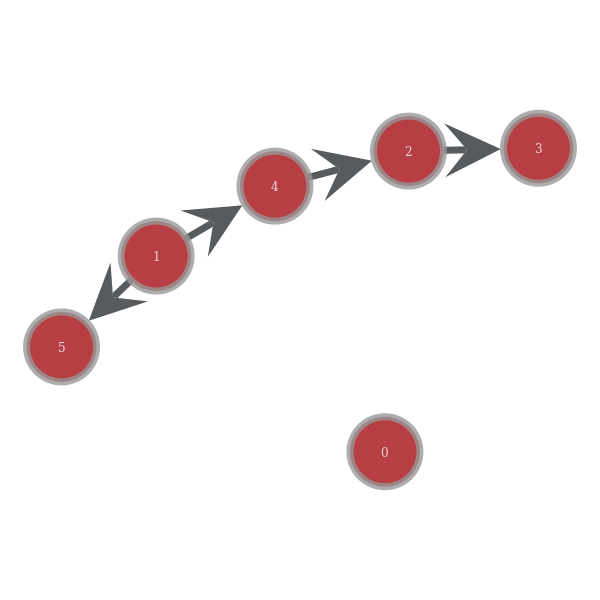

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fbb586da8d0, at 0x7fbaf384d2e8>

In [6]:
graph_draw(G, vertex_text = G.vertex_index)

In [7]:
june_1_data = '/home/ryan/git-repos/bitcoin_networks/ether_data/final_etherum_data/june_1_data/june_1_edge_list.csv'
edge_list = []
counter = 0
with open(june_1_data, 'r') as f:
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        counter += 1
        if counter > 10:
            break
        edge_list.append(row)
f.close()
edge_list = [[edge[0], edge[1]] for edge in edge_list]

In [8]:
edge_list

[['109834', '191506'],
 ['109834', '58972'],
 ['13153', '129593'],
 ['109834', '94885'],
 ['13153', '25891'],
 ['13153', '153056'],
 ['13153', '132116'],
 ['138409', '199185'],
 ['231290', '231291'],
 ['13480', '191113']]

In [9]:
nodes = []
for row in edge_list:
    nodes.append(row[0])
    nodes.append(row[1])
nodes = set(nodes)

In [10]:
# Add necessary nodes
F = graph_tool.Graph()
vprop_label = F.new_vertex_property("string")
for node in nodes:
    if not graph_tool.util.find_vertex(F, vprop_label, node):
        v = F.add_vertex()
        vprop_label[v] = node    
        
# After we're sure the nodes are present, add the edges.


In [11]:
edge_list_2 = [
    [1, 3],
    [1, 2]
]
G.add_edge_list(edge_list_2)

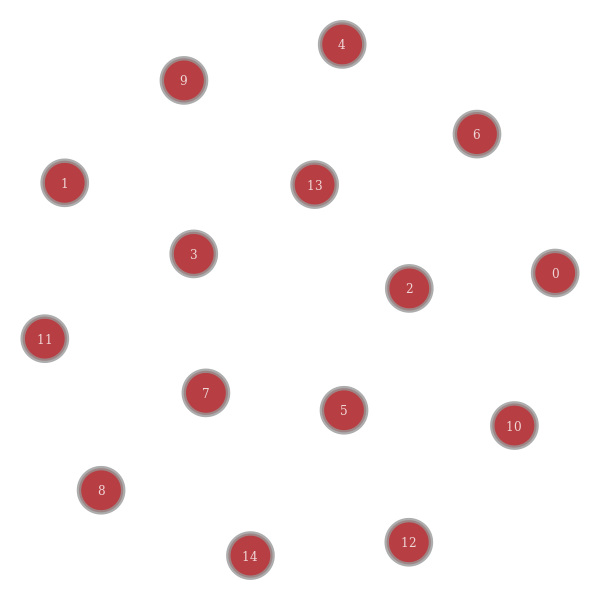

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fbaf3871908, at 0x7fbaf3872320>

In [12]:
graph_draw(F, vertex_text = F.vertex_index)

In [13]:
G.remove_vertex(0)

In [14]:
G.add_vertex(10)

<generator object Graph.add_vertex.<locals>.<genexpr> at 0x7fbaf384a990>

In [15]:
G.clear_vertex(3)

### Recreate graph every time using add_edge_list

In [2]:
data_file = '/home/ryan/git-repos/bitcoin_networks/ether_data/final_etherum_data/june_1_data/july_1_edge_list.csv'
def get_data_buckets(datafile):
    start_time = 1498867200
    edge_list = []
    with open(datafile, 'r') as f:
        reader = csv.reader(f, delimiter=' ')
        for row in reader:
            edge_list.append(row)
    f.close()

    #iterate through the edge list, and create hourly sublists.
    bucket_list = []
    bucket = []

    while len(edge_list) > 1:
        end_time = start_time + (3600 * 24)
        edge = edge_list.pop() # Popping goes in reverse order.
        # Get the 1 hour boundary value.
        bucket_boundary = 3600 * (len(bucket_list) + 1)
        cur_time = edge[-1]
        bound = (end_time - bucket_boundary)
        if int(edge[-1]) < end_time - bucket_boundary:
            bucket_list.append(bucket)
            bucket = []
        else:
            bucket.append(edge)
    # Append the final bucket
    bucket_list.append(bucket)
    return bucket_list


In [3]:
def get_n_largest_components(G, n):
    v, hist = graph_tool.topology.label_components(G)
    n_component_labels = hist.argsort()[-n:]
    
    graph_list = []
    for value in n_component_labels:
        graph_list.append(graph_tool.GraphView(G, vfilt=(v.a==value)))
    return graph_list

In [4]:
bucket_list = get_data_buckets(data_file)

In [5]:
bucket_list

[[['808623', '351375', '89998242030000000000', '1498953598'],
  ['2223206', '1532551', '899466370000000000', '1498953592'],
  ['3030339', '3031961', '74966463992646112', '1498953592'],
  ['2806552', '3004686', '1000999999999999872', '1498953592'],
  ['2223206', '1130386', '321186430000000000', '1498953592'],
  ['3029076', '3029524', '1575000000000000', '1498953592'],
  ['3029274', '3030872', '999781435005907038', '1498953592'],
  ['2748168', '3032169', '60000000000000000', '1498953592'],
  ['2951101', '3030299', '17000000000000000', '1498953592'],
  ['1047982', '518125', '508140820000000000', '1498953592'],
  ['1215916', '1511313', '3000000000000000', '1498953592'],
  ['2432279', '2677437', '250000000000000000', '1498953592'],
  ['93779', '518125', '532416330000000000', '1498953592'],
  ['724480', '518125', '1206185790000000000', '1498953592'],
  ['1771547', '518125', '518082040000000000', '1498953592'],
  ['728779', '518125', '1139443440000000000', '1498953592'],
  ['61740', '518125',

### Examine Largest Component

In [9]:
for i in range(24 - 4 + 1):
    cur_list = []
    for j in range(4):
        cur_list += bucket_list[i + j]
    # Graph tool appears to only consider the first two columns.
#     transferred_value = [float(val[3]) for val in cur_list]
    cur_list = [[val[0], val[1], val[2]] for val in cur_list]
    G = graph_tool.Graph()
    if i == 19:
        F = graph_tool.Graph(directed=True)
        eprop_value = F.new_edge_property('double')
        F.add_edge_list(cur_list, hashed=True, string_vals=True, eprops=[eprop_value])

    
        
    eprop_value = G.new_edge_property('double')
    G.add_edge_list(cur_list, hashed=True, string_vals=True, eprops=[eprop_value])
    if i != 20:
        del G

In [155]:
G.properties(G.get_edges())

TypeError: 'InternalPropertyDict' object is not callable

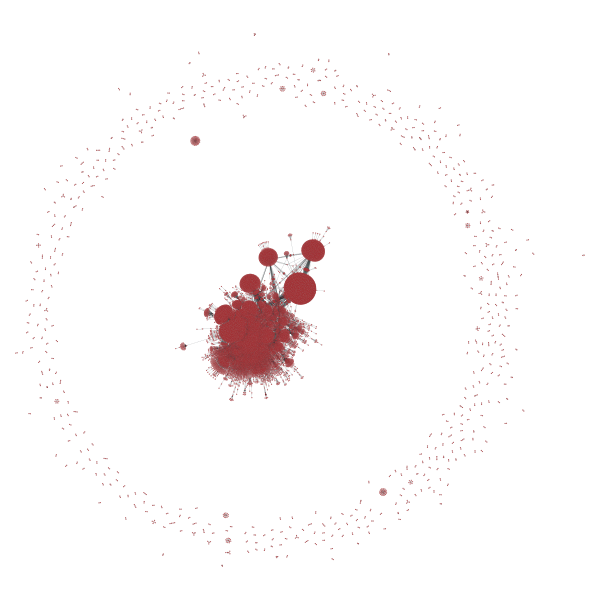

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f91f39f5ef0, at 0x7f91f6ef1b00>

In [7]:
graph_draw(F)

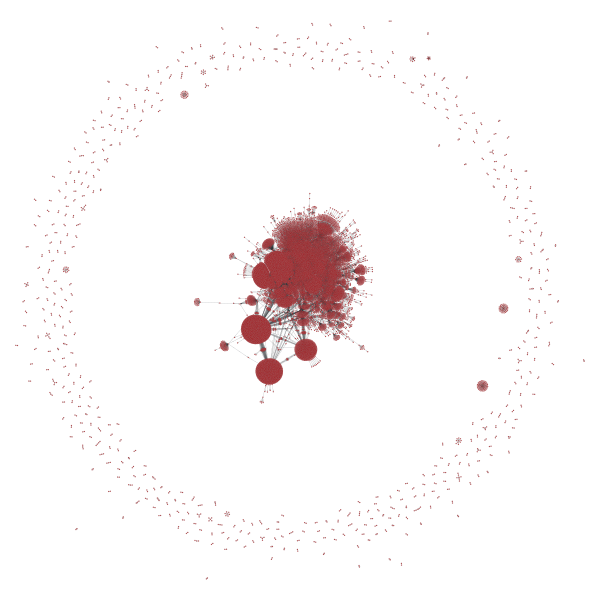

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f925c188630, at 0x7f91f72a31d0>

In [8]:
graph_draw(G)

In [145]:
u = graph_tool.topology.label_largest_component(G)

In [146]:
l = graph_tool.GraphView(G, vfilt=u)

In [157]:
graph_draw(l, edge_text=l.edge_properties[eprop_value])

KeyError: ('e', <PropertyMap object with key type 'Edge' and value type 'double', for Graph 0x7f9e3f7c75c0, at 0x7f9e8441b9b0>)

In [139]:
l.num_vertices()

1114

In [48]:
degs = l.get_in_degrees(l.get_vertices())

In [49]:
import numpy as np

In [51]:
np.histogram(degs, bins = [i for i in range(105)])

(array([  0, 378, 649,  36,  14,  12,   4,   2,   2,   1,   3,   3,   0,
          1,   1,   1,   0,   0,   1,   1,   0,   1,   0,   0,   0,   0,
          0,   1,   0,   1,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  

### Examine multiple components

In [113]:
def get_n_largest_components(G, n):
    v, hist = graph_tool.topology.label_components(G)
    n_component_labels = hist.argsort()[-n:]
    
    graph_list = []
    for value in n_component_labels:
        graph_list.append(graph_tool.GraphView(G, vfilt=(v.a==value)))
    return graph_list

In [109]:
v, hist = graph_tool.topology.label_components(G)
# hist is the number of nodes with a given label
# v is the label of each node.
# Want to get the indices of the n largest values of hist,
# then create subgraphs out of nodes with those indices as labels
# v.a are index id's

graph_list = []
important_values = hist.argsort()[-3:]
for value in important_values:
    graph_list.append(graph_tool.GraphView(G, vfilt=(v.a==value)))
# # if node has important value label, create a subgraph
# v = graph_tool.GraphView(G, vfilt=(v.a==important_values[1]))

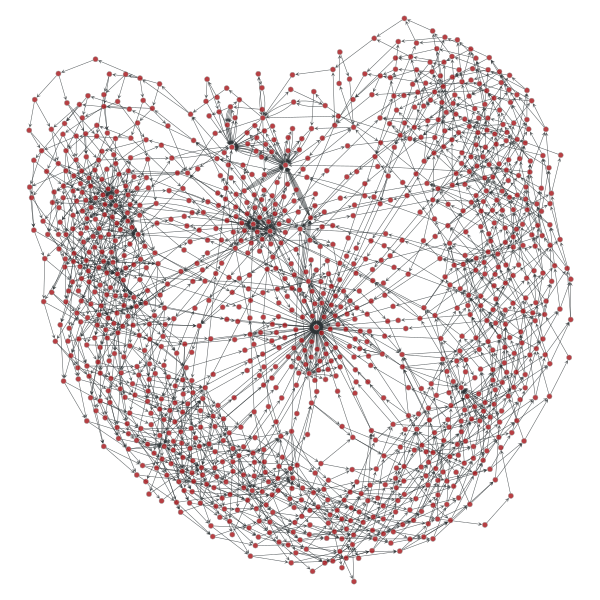

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f9ea6e92a90, at 0x7f9e3685b198>

In [115]:
test_graph = graph_list[2]
graph_draw(graph_list[2])

In [158]:
in_degs = test_graph.get_in_degrees(test_graph.get_vertices())

In [159]:
out_degs = test_graph.get_out_degrees(test_graph.get_vertices())

In [160]:
clustering_coefficient = graph_tool.clustering.global_clustering(test_graph)

In [161]:
clustering_coefficient

(0.00613625635915456, 0.002694987039640478)

In [165]:
for i in range(10):
    print(graph_tool.topology.pseudo_diameter(test_graph))

(18.0, (<Vertex object with index '16' at 0x7f9e37a98390>, <Vertex object with index '5560' at 0x7f9e37a98990>))
(18.0, (<Vertex object with index '16' at 0x7f9e37a98990>, <Vertex object with index '5560' at 0x7f9e37a98930>))
(18.0, (<Vertex object with index '16' at 0x7f9e37a98930>, <Vertex object with index '5560' at 0x7f9e37a98390>))
(18.0, (<Vertex object with index '16' at 0x7f9e37a98390>, <Vertex object with index '5560' at 0x7f9e37a98990>))
(18.0, (<Vertex object with index '16' at 0x7f9e37a98990>, <Vertex object with index '5560' at 0x7f9e37a98930>))
(18.0, (<Vertex object with index '16' at 0x7f9e37a98930>, <Vertex object with index '5560' at 0x7f9e37a98390>))
(18.0, (<Vertex object with index '16' at 0x7f9e37a98390>, <Vertex object with index '5560' at 0x7f9e37a98990>))
(18.0, (<Vertex object with index '16' at 0x7f9e37a98990>, <Vertex object with index '5560' at 0x7f9e37a98930>))
(18.0, (<Vertex object with index '16' at 0x7f9e37a98930>, <Vertex object with index '5560' at 0

In [163]:
graph_tool.topology.pseudo_diameter(test_graph)

(18.0,
 (<Vertex object with index '16' at 0x7f9e37a98870>,
  <Vertex object with index '5560' at 0x7f9e37a98750>))

### JSON Test

In [169]:
import json

In [196]:
sub_val1 = {
    "a":1,
    "b":2
}

sub_val2 = {
    "a":8,
    "b":4
}

sub_val3 = {
    "a":9,
    "b":7
}

json_list = [sub_val1, sub_val2, sub_val3]
json.dumps(json_list)

'[{"a": 1, "b": 2}, {"a": 8, "b": 4}, {"a": 9, "b": 7}]'

In [195]:
with open('test.json', 'w') as f:
    json.dump(json_list, f, indent=4)

# Final Functions

### from the main csv, get all dates within x hours of unix epoch timestamp

In [124]:
big_data = '/home/ryan/git-repos/bitcoin_networks/ether_data/final_etherum_data/time_sorted_ethereum_edge_list.csv'

# Small datafiles to be created.
june_1_data = '/home/ryan/git-repos/bitcoin_networks/ether_data/final_etherum_data/june_1_data/june_1_edge_list.csv'
july_1_data = '/home/ryan/git-repos/bitcoin_networks/ether_data/final_etherum_data/june_1_data/july_1_edge_list.csv'

start_time = 1498867200


def get_date_edge_list(big_data, small_data, start_time, num_hours):
    end_time = start_time + (3600 * num_hours)
    edge_list = []
    with open(big_data, 'r') as f:
        reader = csv.reader(f, delimiter=' ')
        for row in reader:
            if float(row[-1]) > float(end_time):
                break
            if float(row[-1]) > float(start_time):
                edge_list.append(row)
    f.close()
    with open(small_data, 'w') as f:
        writer = csv.writer(f, delimiter=' ')
        writer.writerows(edge_list)
    f.close()


In [125]:
data_file = '/home/ryan/git-repos/bitcoin_networks/ether_data/final_etherum_data/june_1_data/july_1_edge_list.csv'
def get_data_buckets(datafile, start_time, num_hours):
    edge_list = []
    with open(datafile, 'r') as f:
        reader = csv.reader(f, delimiter=' ')
        for row in reader:
            edge_list.append(row)
    f.close()

    #iterate through the edge list, and create hourly sublists.
    bucket_list = []
    bucket = []

    while len(edge_list) > 1:
        end_time = start_time + (3600 * num_hours)
        edge = edge_list.pop() # Popping goes in reverse order.
        # Get the 1 hour boundary value.
        bucket_boundary = 3600 * (len(bucket_list) + 1)
        cur_time = edge[-1]
        bound = (end_time - bucket_boundary)
        if int(edge[-1]) < end_time - bucket_boundary:
            bucket_list.append(bucket)
            bucket = []
        else:
            bucket.append(edge)
    # Append the final bucket
    bucket_list.append(bucket)
    return bucket_list


In [126]:
def get_n_largest_components(G, num_components):
    v, hist = graph_tool.topology.label_components(G)
    n_component_labels = hist.argsort()[-num_components:]

    graph_list = []
    for value in n_component_labels:
        graph_list.append(graph_tool.GraphView(G, vfilt=(v.a == value)))
    return graph_list



In [144]:
def gather_metrics(bucket_list, num_hours, window_size, start_time):
    data_dump = {}
    for i in range(num_hours - window_size + 1):
        cur_list = []
        for j in range(window_size):
            cur_list += bucket_list[i + j]

        G = graph_tool.Graph()
        G.add_edge_list(cur_list, hashed=True, string_vals=True)
        tot_vertices = G.num_vertices()
        tot_in_degrees = G.get_in_degrees(G.get_vertices())
        tot_out_degrees = G.get_out_degrees(G.get_vertices())
        print(tot_in_degrees == tot_out_degrees)
        tot_clustering_coefficient = graph_tool.clustering.global_clustering(G)  # Value, stddev
        # The total value traded within this window.
        tot_value = [float(val[2]) for val in cur_list]
        tot_value = sum(tot_value)

        subgraphs = get_n_largest_components(G, 3)
        subgraphs_data_list = []
        for graph in subgraphs:
            sub_vertices = graph.num_vertices()
            sub_in_degrees = graph.get_in_degrees(G.get_vertices())
            sub_out_degrees = graph.get_out_degrees(G.get_vertices())
#             print(sub_in_degrees == sub_out_degrees)
            sub_clustering_coefficient = graph_tool.clustering.global_clustering(graph)

            subgraph_data = {
                "num_vertices": sub_vertices,
                "in_degrees": sub_in_degrees.tolist(),
                "out_degrees": sub_out_degrees.tolist(),
                "clustering_coefficient": sub_clustering_coefficient
            }
            subgraphs_data_list.append(subgraph_data)

        iter_timestamp = start_time + 3600 * i
        iter_data = {
            "timestamp": iter_timestamp,
            "total_value": tot_value,
            "num_vertices": tot_vertices,
            "in_degrees": tot_in_degrees.tolist(),
            "out_degrees": tot_out_degrees.tolist(),
            "clustering_coefficient": tot_clustering_coefficient,
            "subgraph_1": subgraphs_data_list[0],
            "subgraph_2": subgraphs_data_list[1],
            "subgraph_3": subgraphs_data_list[2]
        }

        data_dump['iter_{}'.format(i)] = iter_data
    return data_dump


In [145]:
def main_collect_time_series(infile, outfile):
    start_time = 1498867200

    big_data = '/home/ryan/git-repos/bitcoin_networks/ether_data/final_etherum_data/time_sorted_ethereum_edge_list.csv'
    july_1_data = '/home/ryan/git-repos/bitcoin_networks/ether_data/final_etherum_data/june_1_data/july_1_edge_list.csv'

    # Get all transaction data within a given window
    bucket_list = get_data_buckets(infile, start_time=start_time, num_hours=24)

    # iterate through the data in hour increments.
    num_hours = 24
    window_size = 4

    data_dump = gather_metrics(bucket_list, num_hours, window_size, start_time)

    with open(outfile, 'w') as f:
        json.dump(data_dump, f)
        f.close()

In [146]:
def read_data(datafile):
    with open(datafile, 'r') as f:
        results = json.load(f)
    f.close()
    return results


In [147]:
def get_largest_component(iter_data):
    # As we experiment with different window sizes, it may prove useful to look at the different subgraphs.
    # However, for now, lets just look at the largest.
    largest_graph = iter_data['subgraph_1']
    subgraph_2 = iter_data['subgraph_2']
    subgraph_3 = iter_data['subgraph_3']
    if largest_graph['num_vertices'] < subgraph_2['num_vertices']:
        largest_graph = subgraph_2
    if largest_graph['num_vertices'] < subgraph_3['num_vertices']:
        largest_graph = subgraph_3
    return largest_graph


In [159]:
def get_deltas(xvals, yvals):
    new_list = []
    for i in range(1, len(yvals)):
        new_list.append(yvals[i] - yvals[i-1])
    print(len())
    return xvals[1:], new_list

In [148]:
def extract_data_from_json(data):
    ## Create an ordered list of data from every iteration
    timestamps = []
    num_vertices = []
    num_subgraph_vertices = []
    in_degree_list = []
    subgraph_in_degree_list = []
    out_degree_list = []
    subgraph_out_degree_list = []
    clustering_coefficients = []
    subgraph_clustering_coefficients = []

    average_in_degrees = []
    subgraph_average_in_degrees = []
    average_out_degrees = []
    subgraph_average_out_degrees = []

    # Do some extraction stuff
    num_iters = len(data.keys())
    for i in range(num_iters):
        iter_data = data['iter_{}'.format(i)]
        subgraph_data = get_largest_component(iter_data)
       
        # Timestamp
        timestamps.append(iter_data['timestamp'])
       
        # Number of Vertices
        num_vertices.append(iter_data['num_vertices'])
        num_subgraph_vertices.append(subgraph_data['num_vertices'])
      
        # In Degree Structure
        in_degree_list.append(iter_data['in_degrees'])
        subgraph_in_degree_list.append(subgraph_data['in_degrees'])
        
        # Out Degree Structure
        out_degree_list.append(iter_data['out_degrees'])
        subgraph_out_degree_list.append(subgraph_data['out_degrees'])
        
        #Clustering Coefficients
        clustering_coefficients.append(iter_data['clustering_coefficient'])
        subgraph_clustering_coefficients.append(subgraph_data['clustering_coefficient'])

        # Average In/Out Degrees
        average_in_degrees.append(np.mean(iter_data['in_degrees']))
        subgraph_average_in_degrees.append(np.mean(subgraph_data['in_degrees']))
        average_out_degrees.append(np.mean(iter_data['out_degrees']))
        subgraph_average_out_degrees.append(np.mean(subgraph_data['out_degrees']))

    # Store all extracted lists in a dictionary for convenient plotting.
    results = {
        'timestamps' : timestamps,
        'num_vertices' : num_vertices,
        'num_subgraph_vertices': num_subgraph_vertices,
        'in_degree_list': in_degree_list,
        'subgraph_in_degree_list': subgraph_in_degree_list,
        'out_degree_list': out_degree_list,
        'subgraph_out_degree_list': subgraph_out_degree_list,
        'clustering_coefficients': clustering_coefficients,
        'subgraph_clustering_coefficients': subgraph_clustering_coefficients,
        'average_in_degrees': average_in_degrees,
        'subgraph_average_in_degrees': subgraph_average_in_degrees,
        'average_out_degrees': average_out_degrees,
        'subgraph_average_out_degrees': subgraph_average_out_degrees,
    }

    return results


In [149]:
def main_examine_time_series(datafile):
    loaded_file = read_data(datafile)
    results = extract_data_from_json(loaded_file)

    # Lets try plotting num_vertices vs time

    return results


In [150]:
def get_price_data_between_times(start_time, end_time):
    price_data = []
    with open('../ether_data/epoch_time.json', 'r') as f:
        total_price_data = json.load(f)
    f.close()
    
    total_price_data = total_price_data['data']
    for data in total_price_data:
        if int(data['time']) > end_time:
            break
        if int(data['time']) > start_time:
            price_data.append([int(data['time']), int(data['value'])])
    return price_data

## Make plots of the data

In [151]:
july_1_data = '/home/ryan/git-repos/bitcoin_networks/ether_data/final_etherum_data/june_1_data/july_1_edge_list.csv'

main_collect_time_series(infile = july_1_data, outfile='/home/ryan/git-repos/bitcoin_networks/code/test_data_1.json', )
results = main_examine_time_series('/home/ryan/git-repos/bitcoin_networks/code/test_data_1.json')

[ True False False ..., False False False]
[False False False ..., False False False]
[ True False  True ..., False False False]
[False False False ..., False False False]
[False False False ..., False False False]
[False False  True ..., False False False]
[False False False ..., False False False]
[False False False ..., False False False]
[ True False  True ..., False False False]
[False False False ..., False False False]
[False False  True ..., False False False]
[False False False ..., False False False]
[False False False ..., False False False]
[False False False ..., False False False]
[False False False ..., False False False]
[ True False False ..., False False False]
[False False False ..., False False False]
[False False False ..., False False False]
[False False False ..., False False False]
[ True False  True ..., False False False]
[False False False ..., False False False]


In [135]:
results.keys()

dict_keys(['out_degree_list', 'average_in_degrees', 'subgraph_clustering_coefficients', 'subgraph_in_degree_list', 'num_subgraph_vertices', 'num_vertices', 'subgraph_average_out_degrees', 'in_degree_list', 'subgraph_average_in_degrees', 'subgraph_out_degree_list', 'average_out_degrees', 'clustering_coefficients', 'timestamps'])

In [136]:
network_timestamps = results['timestamps']
num_vertices = results['num_vertices']
num_subgraph_vettices = results['num_subgraph_vertices']

In [137]:
price_data = get_price_data_between_times(1498867200, 1498939200)
price_timestamps = [data[0] for data in price_data]
prices = [data[1] for data in price_data]

In [ ]:
results['']

### Relationship between number of vertices and price

Text(0.5,1,'Ratio of Vertices')

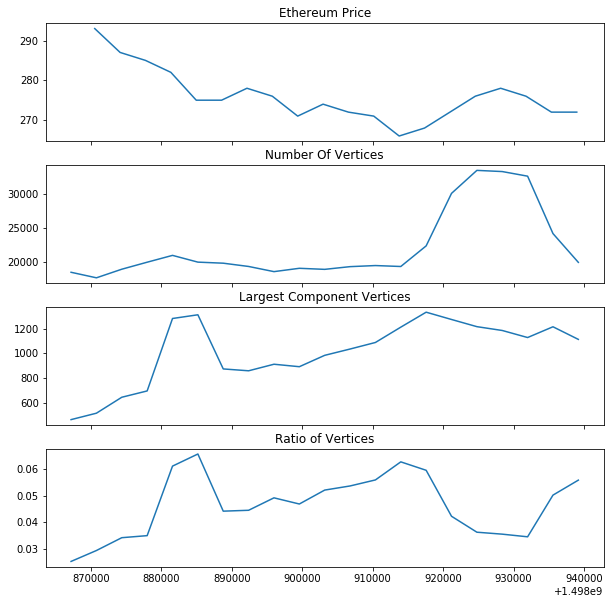

In [138]:
## Examine relationship between number of vertices
ratios = []
for i in range(len(num_vertices)):
    ratios.append(float(num_subgraph_vettices[i])/float(num_vertices[i]))
    
    
f, axarr = plt.subplots(4, sharex=True, figsize=(10, 10))
axarr[0].plot(price_timestamps, prices)
axarr[0].set_title('Ethereum Price')
axarr[1].plot(network_timestamps, num_vertices)
axarr[1].set_title('Number Of Vertices')
axarr[2].plot(network_timestamps, num_subgraph_vettices)
axarr[2].set_title('Largest Component Vertices')
axarr[3].plot(network_timestamps, ratios)
axarr[3].set_title('Ratio of Vertices')





### Plot the change in values

In [167]:
len(price_timestamps[1:])

19

20
20
20
19


ValueError: x and y must have same first dimension, but have shapes (20,) and (19,)

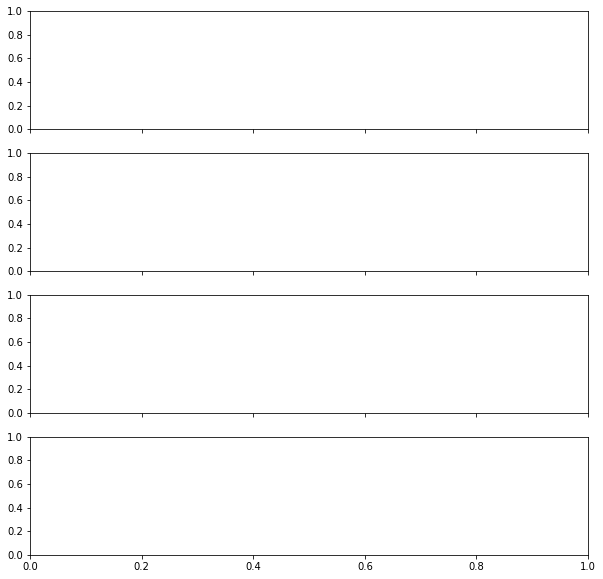

In [165]:
## Examine relationship between number of vertices
ratios = []
for i in range(len(num_vertices)):
    ratios.append(float(num_subgraph_vettices[i])/float(num_vertices[i]))
 
print(len(price_timestamps))    
print(len(prices))

price_delta_timestamps, price_deltas = get_deltas(timestamps, prices)    
print(len(price_delta_timestamps))    
print(len(price_deltas))

f, axarr = plt.subplots(4, sharex=True, figsize=(10, 10))
axarr[0].plot(price_delta_timestamps, price_deltas)
axarr[0].set_title('Ethereum Price')
axarr[1].plot(network_timestamps, num_vertices)
axarr[1].set_title('Number Of Vertices')
axarr[2].plot(network_timestamps, num_subgraph_vettices)
axarr[2].set_title('Largest Component Vertices')
axarr[3].plot(network_timestamps, ratios)
axarr[3].set_title('Ratio of Vertices')


### Relationship between Global Clustering Coefficeient and price

Text(0.5,1,'Subgraph Clustering Coefficient')

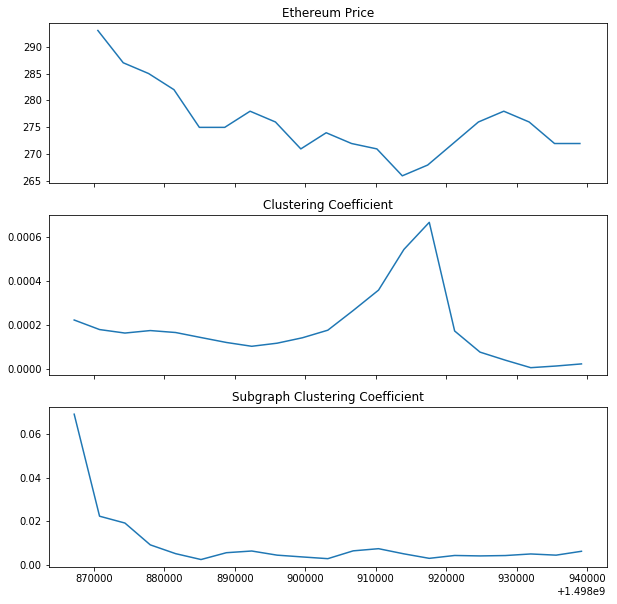

In [152]:
## Examine Clustering Coefficient Relationship
f, axarr = plt.subplots(3, sharex=True, figsize=(10, 10))
axarr[0].plot(price_timestamps, prices)
axarr[0].set_title('Ethereum Price')
axarr[1].plot(network_timestamps, [val[0] for val in results['clustering_coefficients']])
axarr[1].set_title('Clustering Coefficient')
axarr[2].plot(network_timestamps, [val[0] for val in results['subgraph_clustering_coefficients']])
axarr[2].set_title('Subgraph Clustering Coefficient')


### Relationship between the degree structure and price

Text(0.5,1,'Average Subgraph Out Degree')

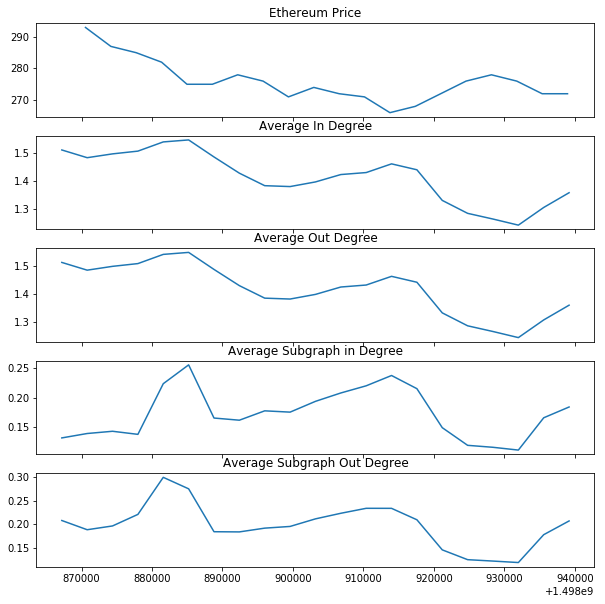

In [153]:
## Examine In/Out Degree Relationship
# TODO: Figure out what is going on with the average in degree and average out degree
f, axarr = plt.subplots(5, sharex=True, figsize=(10, 10))
axarr[0].plot(price_timestamps, prices)
axarr[0].set_title('Ethereum Price')
axarr[1].plot(network_timestamps, results['average_in_degrees'])
axarr[1].set_title('Average In Degree')
axarr[2].plot(network_timestamps, results['average_out_degrees'])
axarr[2].set_title('Average Out Degree')
axarr[3].plot(network_timestamps, results['subgraph_average_in_degrees'])
axarr[3].set_title('Average Subgraph in Degree')
axarr[4].plot(network_timestamps, results['subgraph_average_out_degrees'])
axarr[4].set_title('Average Subgraph Out Degree')

In [156]:
results['average_in_degrees'] == results['average_out_degrees']

True

In [205]:
def extract_subgraphs(iter_dict):
    graphs = [iter_dict['subgraph_1'], iter_dict['subgraph_2'], iter_dict['subgraph_3']]
    # use this line if we are interested in examining the second and third largest components
    graphs = [graph for graph in graphs if graph['sub_vertices'] > 10]
    print(len(graphs))
    
    

In [201]:
# First, make a plot of how the number of nodes changes over time
nodes_list = []
timestamps = []
for i in range(len(test_data.keys())):
    num_nodes = test_data['iter_{}'.format(i)]['tot_vertices']
    nodes_list.append(num_nodes)
    timestamp = test_data['iter_{}'.format(i)]['timestamp']
    timestamps.append(timestamp)


In [5]:
import datetime

for monthinteger in range(1, 13):
    month = datetime.date(1900, monthinteger, 1).strftime('%B')

    print(month)


January
February
March
April
May
June
July
August
September
October
November
December


### Creating Graphs from edge lists:

In [12]:
J = load_graph_from_csv(file_name='/home/ryan/git-repos/bitcoin_networks/ether_data/edge_list_subsets/edges_from_22_May_2017_buckets_48_window_10.csv', directed=True, eprop_types=['double', 'double'], eprop_names = ['value_exchanged', 'time'], string_vals=True, skip_first=False, csv_options={'delimiter':' ', "quotechar":'"'})

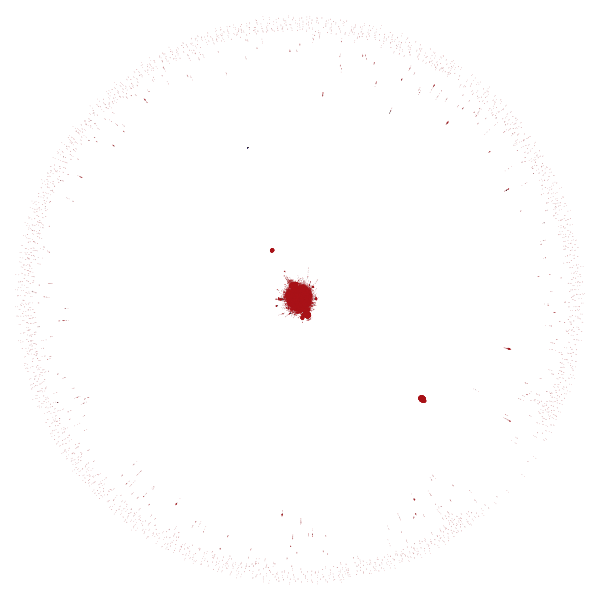

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f91f3ae2d30, at 0x7f925c188780>

In [13]:
graph_draw(J)